In [20]:
# load packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import wasserstein_distance#import random
import matplotlib.pyplot as plt
import random


In [21]:
# load the data

df = pd.read_csv('../data/spotify_dataset_cleaned.csv')



In [22]:
# drop na values

df = df.dropna()

# remove duplicates track ids

df = df.drop_duplicates(subset='track_id')

print(df.shape)

# replace the current index with a new one that starts from 0

df = df.reset_index(drop=True)

# remove column Unnamed: 0

df = df.drop(['Unnamed: 0'], axis=1)

# drop the non-numeric columns

df_reduced = df.drop(['artists', 'track_name', 'album_name'], axis=1)

# replace the current index with a new one that starts from 0

df = df.reset_index(drop=True)



(89740, 147)


In [23]:

# standardize the data (except for track_id)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_reduced.drop('track_id', axis=1))


In [24]:

# Train Gaussian Mixture Model
gmm = GaussianMixture(n_components=15, random_state=42)  # You can tune the number of components
gmm.fit(df_scaled)

GaussianMixture(n_components=15, random_state=42)

In [25]:
# Assign each song to a cluster
df['cluster'] = gmm.predict(df_scaled)

In [26]:
# Function to get similar songs based on Earth Mover's Distance within the same cluster
def get_similar_songs(track_ids, n_recommendations=10):
    track_indices = df.index[df['track_id'].isin(track_ids)].tolist()
    track_clusters = df.loc[track_indices, 'cluster'].values
    unique_clusters = np.unique(track_clusters)
    
    # Aggregate features of the input tracks by computing the mean
    track_features = np.mean(df_scaled[track_indices], axis=0).reshape(1, -1)
    
    distances = []
    
    for cluster in unique_clusters:
        cluster_songs = df[df['cluster'] == cluster]
        cluster_indices = cluster_songs.index
        cluster_features = df_scaled[cluster_indices]
        
        for idx, song_features in zip(cluster_indices, cluster_features):
            distance = wasserstein_distance(track_features.flatten(), song_features)
            distances.append((df.loc[idx, 'track_id'], distance))
    
    distances = sorted(distances, key=lambda x: x[1])
    similar_songs = [track for track, _ in distances[:n_recommendations]]
    
    return similar_songs

In [27]:
# Testing the newly created algorithm on examples
track_ids_and_genres = {
    'rap': ['1Mt7JLzBMXjTVKcdeD437t', '6tDxrq4FxEL2q15y37tXT9'],
    'pop': ['1u8c2t2Cy7UBoG4ArRcF5g', '09CtPGIpYB4BrO8qb1RGsF'],
    'hard_rock': ['2zYzyRzz6pRmhPzyfMEC8s', '3Jnxngdff0lVu2rza1GVx6'],
    'balade': ['4q2lRiodoQnyFO65watkse', '2A6yzRGMgSQCUapR2ptm6A'],
    'edm': ['0nrRP2bk19rLc0orkWPQk2', '6Wtc1K3dvTIEsWU3rSIZXn']
}

# Initialize the results DataFrame
result_df = pd.DataFrame(columns=[
    'genre', 'input song 1', 'input song 2',
    'song 1', 'song 2', 'song 3', 'song 4', 'song 5',
    'song 6', 'song 7', 'song 8', 'song 9', 'song 10'   
])

# Loop through the track IDs and genres
for genre, track_ids in track_ids_and_genres.items():
    similar_songs = get_similar_songs(track_ids)
    
    similar_songs_df = df[df['track_id'].isin(similar_songs)][['artists', 'track_name']]
    similar_songs_df['song'] = similar_songs_df.apply(lambda row: f"{row['track_name']} ({row['artists']})", axis=1)
    
    row = {
        'genre': genre,
        'input song 1': f"{df[df['track_id'] == track_ids[0]]['track_name'].values[0]} ({df[df['track_id'] == track_ids[0]]['artists'].values[0]})",
        'input song 2': f"{df[df['track_id'] == track_ids[1]]['track_name'].values[0]} ({df[df['track_id'] == track_ids[1]]['artists'].values[0]})",
        'song 1': similar_songs_df.iloc[0]['song'],
        'song 2': similar_songs_df.iloc[1]['song'],
        'song 3': similar_songs_df.iloc[2]['song'],
        'song 4': similar_songs_df.iloc[3]['song'],
        'song 5': similar_songs_df.iloc[4]['song'],
        'song 6': similar_songs_df.iloc[5]['song'],
        'song 7': similar_songs_df.iloc[6]['song'],
        'song 8': similar_songs_df.iloc[7]['song'],
        'song 9': similar_songs_df.iloc[8]['song'],
        'song 10': similar_songs_df.iloc[9]['song']   
    }
    
    result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)

print("Recommended songs:")
print(result_df)

# save the results to a csv file

result_df.to_csv('../results/recommended_songs_full_data.csv', index=False)

Recommended songs:
       genre                       input song 1  \
0        rap  Nuthin But A G'Thang (Snoop Dogg)   
1        pop         Blank Space (Taylor Swift)   
2  hard_rock            Highway to Hell (AC/DC)   
3     balade              True (Spandau Ballet)   
4        edm                Wake Me Up (Avicii)   

                                 input song 2  \
0                            Dear Mama (2Pac)   
1                       Sorry (Justin Bieber)   
2  Paranoid (2009 - Remaster) (Black Sabbath)   
3                  True Colors (Cyndi Lauper)   
4  Feel So Close - Radio Edit (Calvin Harris)   

                                              song 1  \
0                                   Dear Mama (2Pac)   
1  Baila Baila Baila - Remix (Ozuna;Daddy Yankee;...   
2                            yaadein (Zaeden;AAKASH)   
3                      Lembranças (Ao Vivo) (Maneva)   
4                   HandClap (Fitz and The Tantrums)   

                                    song 2

In [18]:
# creating a function that returns the average popularity of the playlist

def create_playlist_and_average_popularity():
    # Randomly pick a track ID
    random_track_id = random.choice(df['track_id'].tolist())
    
    # Create a playlist for the random track ID
    similar_songs = get_similar_songs([random_track_id])
    
    # Get the average popularity of the returned playlist
    playlist_df = df[df['track_id'].isin(similar_songs)]
    average_popularity = playlist_df['popularity'].mean()
    
    return random_track_id, average_popularity, playlist_df['popularity']

# Example usage
random_track_id, avg_popularity, playlist_popularity = create_playlist_and_average_popularity()
print(f"Random track ID: {random_track_id}")
print(f"Average popularity of the playlist: {avg_popularity}")


Random track ID: 2Vy4rAw44YHjwI0xIhpxSA
Average popularity of the playlist: 26.6


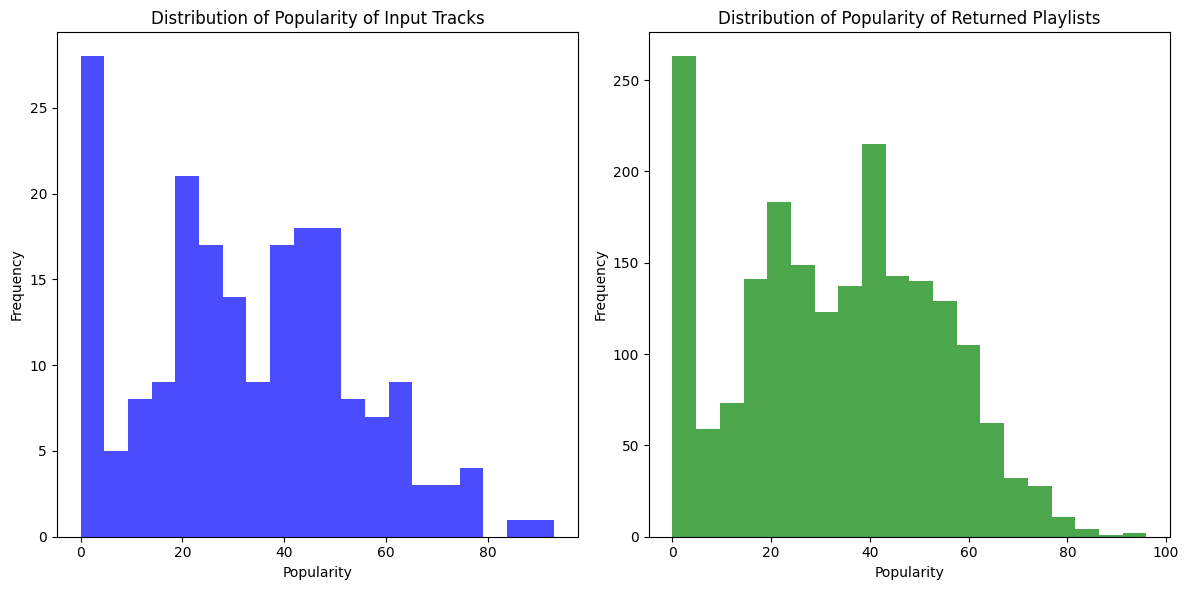

In [28]:
# Testing the hypothesis that the average popularity of the returned playlists is similar to the popularity of the input tracks
# Lists to store popularities
input_popularities = []
returned_popularities = []

# Call the function 200 times
for _ in range(200):
    random_track_id, avg_popularity, playlist_popularity = create_playlist_and_average_popularity()
    input_popularity = df[df['track_id'] == random_track_id]['popularity'].values[0]
    
    input_popularities.append(input_popularity)
    returned_popularities.extend(playlist_popularity)

# Plotting the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(input_popularities, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Popularity of Input Tracks')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(returned_popularities, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Popularity of Returned Playlists')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


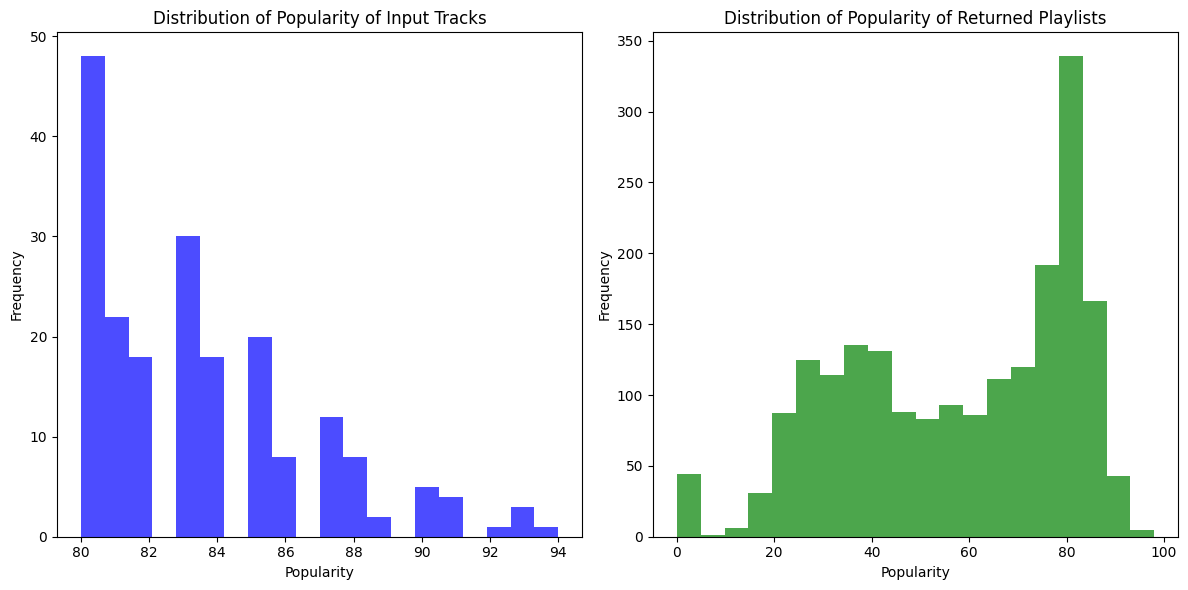

In [29]:



# Testing the popularity bias with input tracks of high popularity
def create_playlist_and_average_popularity():
    # Randomly pick a track ID
    random_track_id = random.choice(df['track_id'].tolist())
    
    # Create a playlist for the random track ID
    similar_songs = get_similar_songs([random_track_id])
    
    # Get the average popularity of the returned playlist
    playlist_df = df[df['track_id'].isin(similar_songs)]
    average_popularity = playlist_df['popularity'].mean()
    
    return random_track_id, average_popularity, playlist_df['popularity']

# Function to select a track ID with popularity primarily between 8 and 10
def select_track_id():
    # Filter tracks with popularity between 8 and 10
    filtered_data = df[(df['popularity'] >= 80) & (df['popularity'] <= 100)]
    
    # Randomly select a track ID from the filtered data
    if not filtered_data.empty:
        random_track_id = random.choice(filtered_data['track_id'].tolist())
    else:
        # Fallback to random selection if no tracks in the desired popularity range
        random_track_id = random.choice(df['track_id'].tolist())
    
    return random_track_id

# Lists to store popularities
input_popularities = []
returned_popularities = []

# Call the function 200 times
for _ in range(200):
    random_track_id = select_track_id()
    similar_songs = get_similar_songs([random_track_id])
    playlist_df = df[df['track_id'].isin(similar_songs)]
    
    input_popularity = df[df['track_id'] == random_track_id]['popularity'].values[0]
    
    input_popularities.append(input_popularity)
    returned_popularities.extend(playlist_df['popularity'])

# Plotting the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(input_popularities, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Popularity of Input Tracks')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(returned_popularities, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Popularity of Returned Playlists')
plt.xlabel('Popularity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
